# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [228]:
#Go to the main directory
#!pip install --editable .
#!pip install pandas
# !pip install wntr
# !pip install pandapower
# !pip install sklearn

#to find requirements
#depfinder -y .

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import required packages

In [2]:
from pathlib import Path
from dreaminsg_integrated_model.src.network_recovery import *
import dreaminsg_integrated_model.src.simulation as simulation
from dreaminsg_integrated_model.src.network_sim_models.integrated_network import *

from dreaminsg_integrated_model.src.network_sim_models.interdependencies import *

from dreaminsg_integrated_model.src.optimizer import *
import dreaminsg_integrated_model.src.plots as model_plots

import random

## Create an IntegratedNetwork object

In [3]:
simple_network = IntegratedNetwork()

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [4]:
MAIN_DIR = Path('..')

network_dir= 'in2'
water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/water.inp'
power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/power.json'
transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_file, power_file, transp_folder, '1ph')

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\water\water.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\power\power.json. Single phase power flow simulation will be used.

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

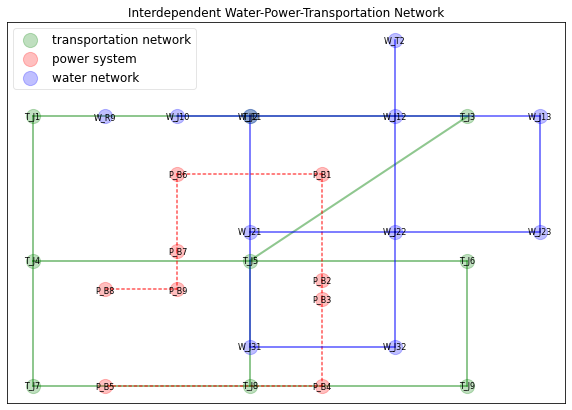

In [6]:
simple_network.generate_integrated_graph(plotting = True)

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [7]:
dependency_file = MAIN_DIR/f"dreaminsg_integrated_model/data/networks/{network_dir}/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [8]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B8,T_J4,power,Bus,125.00
1,P_B7,T_J5,power,Bus,103.08
2,P_B5,T_J7,power,Bus,100.00
3,P_B4,T_J8,power,Bus,100.00
4,P_B6,T_J2,power,Bus,180.28


### Set failed components

In [9]:
scenario_file = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/{}/{}.csv".format('test1', 'motor_failure_net1')

simple_network.set_disrupted_components(scenario_file=scenario_file)
simple_network.get_disrupted_components()

['T_L2', 'P_MP1', 'W_P21', 'W_WP9']

In [10]:
simple_network.pipe_leak_node_generator()

### Set initial crew locations

In [11]:
simple_network.set_init_crew_locs(init_power_loc='T_J8',
init_water_loc='T_J8', init_transpo_loc='T_J8')

## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [12]:
network_recovery = NetworkRecovery(simple_network, sim_step=60)

### (b) Create a simulation object

In [13]:
sim_step = (
    simple_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Generation of random repair order

In [14]:
#Generate a random repair order
repair_order = network_recovery.network.get_disrupted_components()
random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['W_P21', 'W_WP9', 'T_L2', 'P_MP1']


### (d) Generation of event tables

In [15]:
bf_simulation.network_recovery.schedule_recovery(repair_order)

Iteration 1: gap 4642.279088: time 0.000996
Iteration 2: gap 0.000936: time 0.004987
Iteration 3: gap 0.000000: time 0.007978
Iteration 1: gap 0.354227: time 0.000000
Iteration 2: gap 0.000936: time 0.002991
Iteration 3: gap 0.000000: time 0.006978


In [16]:
bf_simulation.expand_event_table(20)

In [17]:
network_recovery.get_event_table().time_stamp

,time_stamp,components,perf_level,component_state
0,60,T_L2,100,Functional
1,60,P_MP1,100,Functional
2,60,W_P21,100,Functional
3,60,W_WP9,100,Functional
99,4740,P_MP1,100,Functional
...,...,...,...,...
25,93120,P_MP1,100,Service Restored
26,93240,T_L2,100,Service Restored
78,93240,W_P21,100,Service Restored
79,93240,W_WP9,100,Service Restored


### (e) Simulation of interdependent effects

In [20]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

resilience_metrics.set_weighted_auc_metrics()


Simulating network conditions at 60 s
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Supply:  0.06939921609795267 Base demand:  0.06939921604

Simulating network conditions at 4740 s
Simulation time:  4740.0 ; Hydraulic time step:  60.0 ; Report time step:  4740
Supply:  0.06939921609917374 Base demand:  0.06939921604

Simulating network conditions at 6060 s
Simulation time:  6060.0 ; Hydraulic time step:  60.0 ; Report time step:  6060
Supply:  0.06939921609951889 Base demand:  0.06939921604

Simulating network conditions at 6120 s
Simulation time:  6120.0 ; Hydraulic time step:  60.0 ; Report time step:  6120
Supply:  0.06939921609801265 Base demand:  0.06939921604

Simulating network conditions at 6180 s
Simulation time:  6180.0 ; Hydraulic time step:  60.0 ; Report time step:  6180
Supply:  0.06939921608238037 Base demand:  0.06939921604

Simulating network conditions at 6240 s
Simulation time:  6240.0 ; Hydraulic time step:  60.0 ; Report time step:  

### (f) Calculation of resilience metric

In [ ]:
# auc = 0.5 * water_auc + 0.5 * power_auc
print(
    "Water AUC: ",
    round(resilience_metrics.water_auc, 3),
    "\t",
    "Power AUC: ",
    round(resilience_metrics.power_auc, 3),
    "\t",
    "Weighted AUC: ",
    round(resilience_metrics.weighed_auc, 3),
)

Water AUC:  0.128 	 Power AUC:  0.965 	 Weighted AUC:  0.546


### Plot the direct and interdependent effects

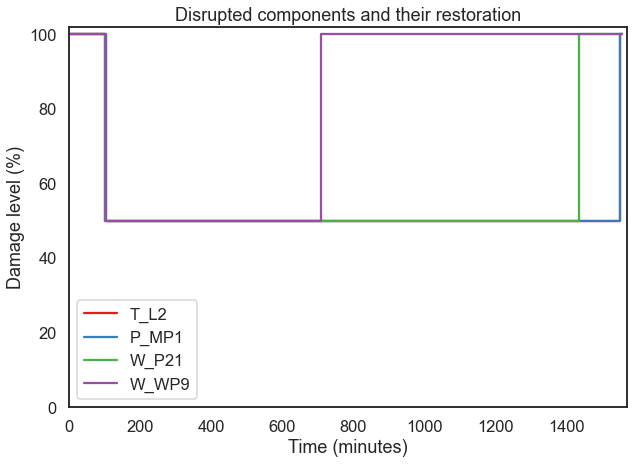

In [ ]:
#Plotting repair curves
model_plots.plot_repair_curves(network_recovery, scatter = False)

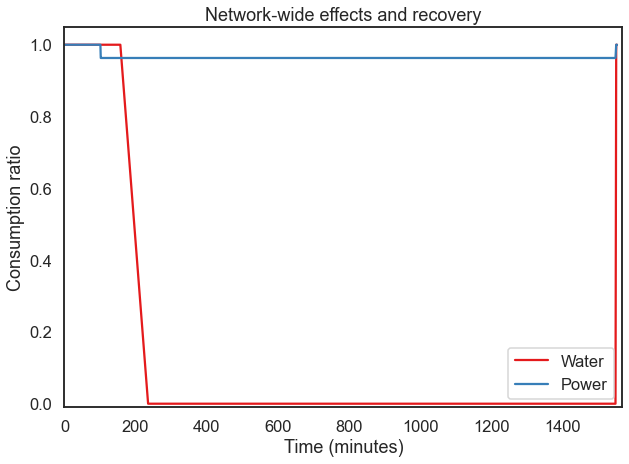

In [ ]:
time_tracker, power_consump_tracker, water_consump_tracker = (
    resilience_metrics.time_tracker, 
    resilience_metrics.power_consump_tracker, 
    resilience_metrics.water_consump_tracker
    )

model_plots.plot_interdependent_effects(
        power_consump_tracker,
        water_consump_tracker,
        time_tracker,
        scatter=False,
    )